In [1]:
!pip install hmmlearn

     |████████████████████████████████| 374 kB 5.3 MB/s 


In [2]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

     |████████████████████████████████| 11.3 MB 5.4 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.3 which is incompatible.


     |████████████████████████████████| 109 kB 5.5 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [46]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import sys
from hmmlearn import hmm
import pandas_datareader.data as pdr
import datetime as dt
 
 

plt.style.use('ggplot')

debut = dt.datetime(2000, 1, 1)
fin = dt.datetime.today().strftime('%Y-%m-%d')
 
class Prediction_Stock(object):
    def __init__(self, company, test_size=0.30,
                 n_hidden_states=4, n_latency_days=1,
                 n_steps_frac_change=50, n_steps_frac_high=10,
                 n_steps_frac_low=10, model=GaussianHMM):
 
        self.company = company
        self.n_latency_days = n_latency_days
 
        self.hmm = model(n_components=n_hidden_states)
 
        self._split_train_test_data(test_size)
 
        self._compute_all_possible_outcomes(
            n_steps_frac_change, n_steps_frac_high, n_steps_frac_low)
 
    def _split_train_test_data(self, test_size):
        data = pdr.DataReader(self.company, 'yahoo', debut, fin)
        _train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)
 
        self._train_data = _train_data
        self._test_data = test_data
 
    @staticmethod
    def _extract_features(data):
        open_price = np.array(data['Open'])
        close_price = np.array(data['Close'])
        high_price = np.array(data['High'])
        low_price = np.array(data['Low'])
        frac_change = (close_price - open_price) / open_price
        frac_high = (high_price - open_price) / open_price
        frac_low = (open_price - low_price) / open_price
 
        return np.column_stack((frac_change, frac_high, frac_low))
 
    def fit(self):
        feature_vector = StockPredictor._extract_features(self._train_data)
 
        self.hmm.fit(feature_vector)
 
    def _compute_all_possible_outcomes(self, n_steps_frac_change,
                                       n_steps_frac_high, n_steps_frac_low):
        frac_change_range = np.linspace(-0.1, 0.1, n_steps_frac_change)
        frac_high_range = np.linspace(0, 0.1, n_steps_frac_high)
        frac_low_range = np.linspace(0, 0.1, n_steps_frac_low)
 
        self._possible_outcomes = np.array(list(itertools.product(
            frac_change_range, frac_high_range, frac_low_range)))
 
    def _get_most_probable_outcome(self, day_index):
        previous_data_start_index = max(0, day_index - self.n_latency_days)
        previous_data_end_index = max(0, day_index - 1)
        previous_data = self._test_data.iloc[previous_data_end_index: previous_data_start_index]
        previous_data_features = StockPredictor._extract_features(
            previous_data)
 
        outcome_score = []
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack(
                (previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))
        most_probable_outcome = self._possible_outcomes[np.argmax(
            outcome_score)]
 
        return most_probable_outcome
 
    def predict_close_price(self, day_index):
        open_price = self._test_data.iloc[day_index]['Open']
        predicted_frac_change, _, _ = self._get_most_probable_outcome(day_index)
        return open_price * (1 + predicted_frac_change)
 
    def predict_close_prices_for_days(self, days):
        predicted_close_prices = []
        for day_index in tqdm(range(days)):
            predicted_close_prices.append(self.predict_close_price(day_index))
 
        test_data = self._test_data[0: days]
        days = np.array(test_data.index, dtype="datetime64[ms]")
        actual_close_prices = test_data['Close']
 
        fig = plt.figure(figsize=(15, 10))
 
        axes = fig.add_subplot(111)
        axes.plot(days, actual_close_prices, 'bo-', label="actual")
        axes.plot(days, predicted_close_prices, 'r+-', label="predicted")
        axes.set_title('{company}'.format(company=self.company))
 
        fig.autofmt_xdate()
 
        plt.legend()
        plt.show()

        test_data['Close Predicted'] = predicted_close_prices
 
        return test_data[['Close', "Close Predicted"]]

100%|██████████| 500/500 [21:23<00:00,  2.57s/it]


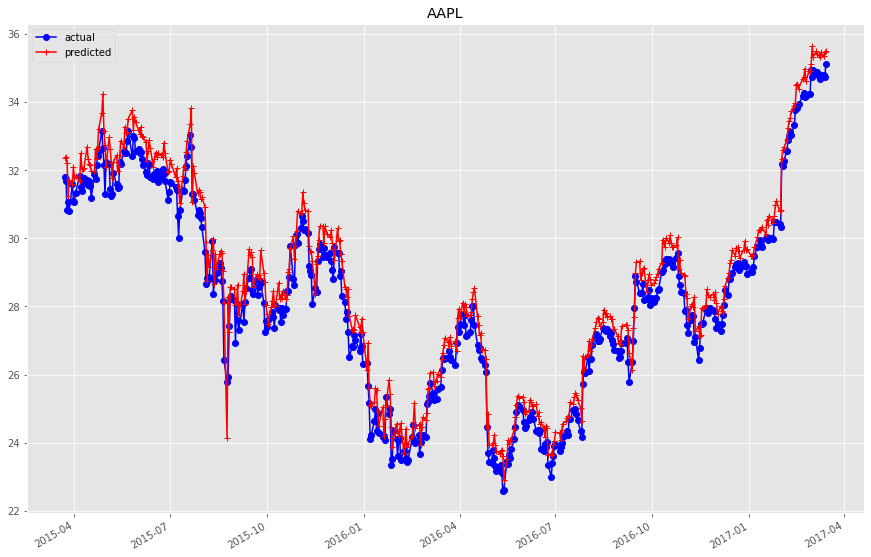

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [52]:
apple_predict = Prediction_Stock(company="AAPL", n_hidden_states=2, test_size=0.30)
apple_predict.fit()
test_pred_df = apple_predict.predict_close_prices_for_days(500)

In [53]:
#Calcul MSE

from sklearn.metrics import mean_squared_error, accuracy_score
mean_squared_error(test_pred_df['Close'], test_pred_df['Close Predicted'])

0.3822474312412038